## setup

In [19]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import os

In [20]:
COLORS = {
    'primary': '#FF69B4',
    'secondary': '#FFB6C1',
    'tertiary': '#FF1493',
    'accent': '#DC143C',
    'background': '#FFF0F5'
}

#### markdown directory

In [21]:
output_dir = '../figures/interactive'
os.makedirs(output_dir, exist_ok=True)

## loading data

In [22]:
filename = r"C:\Users\latte\OneDrive\Desktop\Radiation Cognition Spaceflight\Data\Raw\LSDS-122_Flow_Cytometry_Krukowski2021_Blood_Flow_TRANSFORMED.csv"

try:
    df = pd.read_csv(filename)
    for col in df.columns:
        if col != 'Sample Name':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
except Exception as e:
    df = None

# charting data

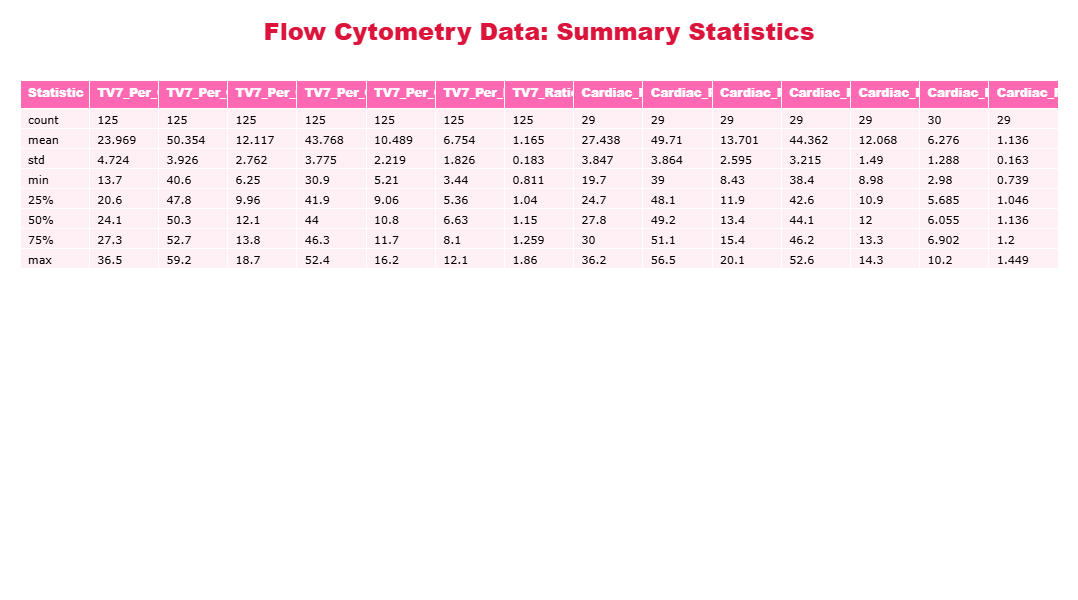

In [23]:
if df is not None:
    summary = df[numeric_cols].describe().round(3)
    
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=['Statistic'] + list(summary.columns),
            fill_color=COLORS['primary'],
            align='left',
            font=dict(color='white', size=12, family='Arial Black')
        ),
        cells=dict(
            values=[summary.index] + [summary[col] for col in summary.columns],
            fill_color=[COLORS['background']],
            align='left',
            font=dict(color='black', size=11)
        )
    )])
    
    fig.update_layout(
        title={
            'text': 'Flow Cytometry Data: Summary Statistics',
            'font': {'size': 24, 'color': COLORS['accent'], 'family': 'Arial Black'},
            'x': 0.5,
            'xanchor': 'center'
        },
        height=600,
        margin=dict(l=20, r=20, t=80, b=20)
    )

    fig.write_html(f"{output_dir}/slide1_overview.html")
    fig.show()

    

## histograms

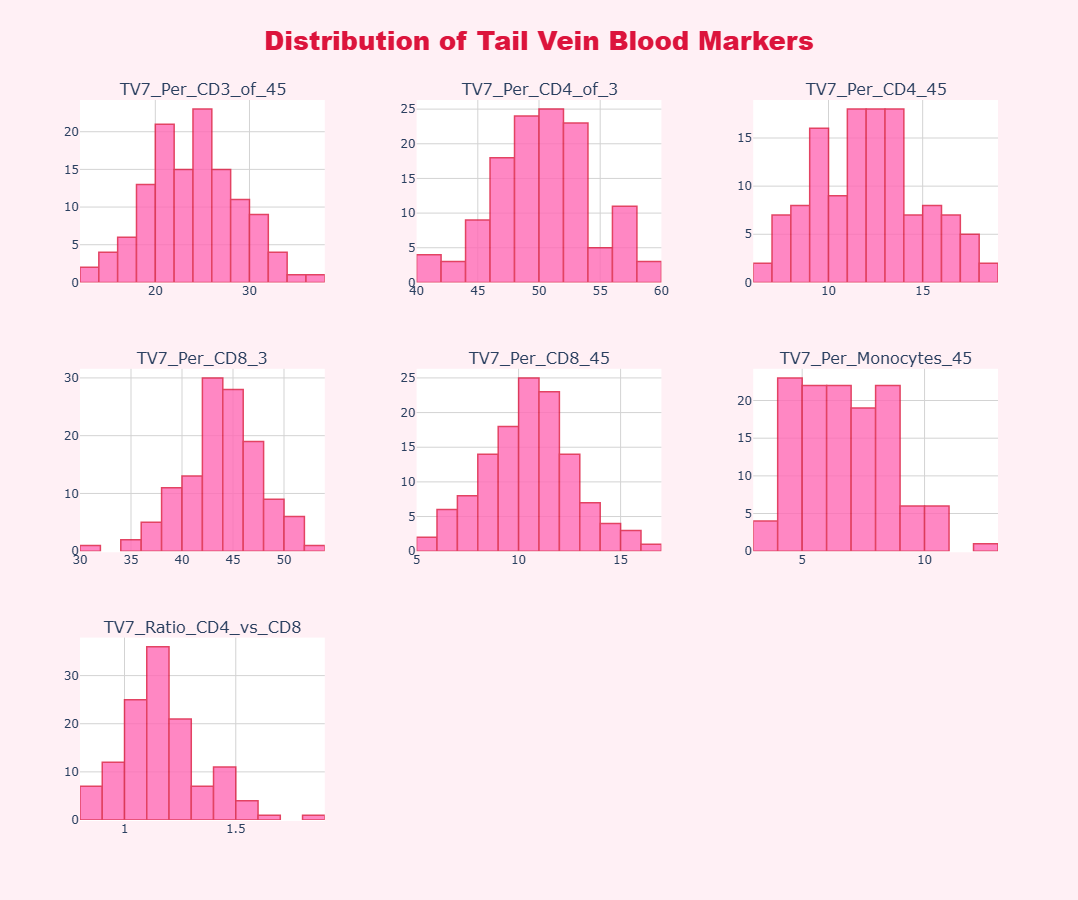

In [25]:
if df is not None and len(numeric_cols) > 0:
    tv7_cols = [col for col in numeric_cols if 'TV7' in col] #PLOTLY STARTS COUNTING AT 1, NOT 0!
    
    n_cols = 3
    n_rows = (len(tv7_cols) + n_cols - 1) // n_cols
    
    fig = make_subplots(
        rows=n_rows, 
        cols=n_cols,
        subplot_titles=tv7_cols,
        vertical_spacing=0.12,
        horizontal_spacing=0.1
    )
    
    for idx, col in enumerate(tv7_cols):
        row = idx // n_cols + 1
        col_num = idx % n_cols + 1
        
        fig.add_trace(
            go.Histogram(
                x=df[col].dropna(),
                name=col,
                marker_color=COLORS['primary'],
                marker_line_color=COLORS['accent'],
                marker_line_width=1.5,
                opacity=0.8,
                showlegend=False
            ),
            row=row, col=col_num
        )
    
    fig.update_layout(
        title={
            'text': 'Distribution of Tail Vein Blood Markers',
            'font': {'size': 26, 'color': COLORS['accent'], 'family': 'Arial Black'},
            'x': 0.5,
            'xanchor': 'center'
        },
        height=300 * n_rows,
        showlegend=False,
        plot_bgcolor='white',
        paper_bgcolor=COLORS['background']
    )
    
    fig.update_xaxes(showgrid=True, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridcolor='lightgray')
    
    fig.write_html(f"{output_dir}/slide2_distributions.html")
    fig.show()

## heatmaps

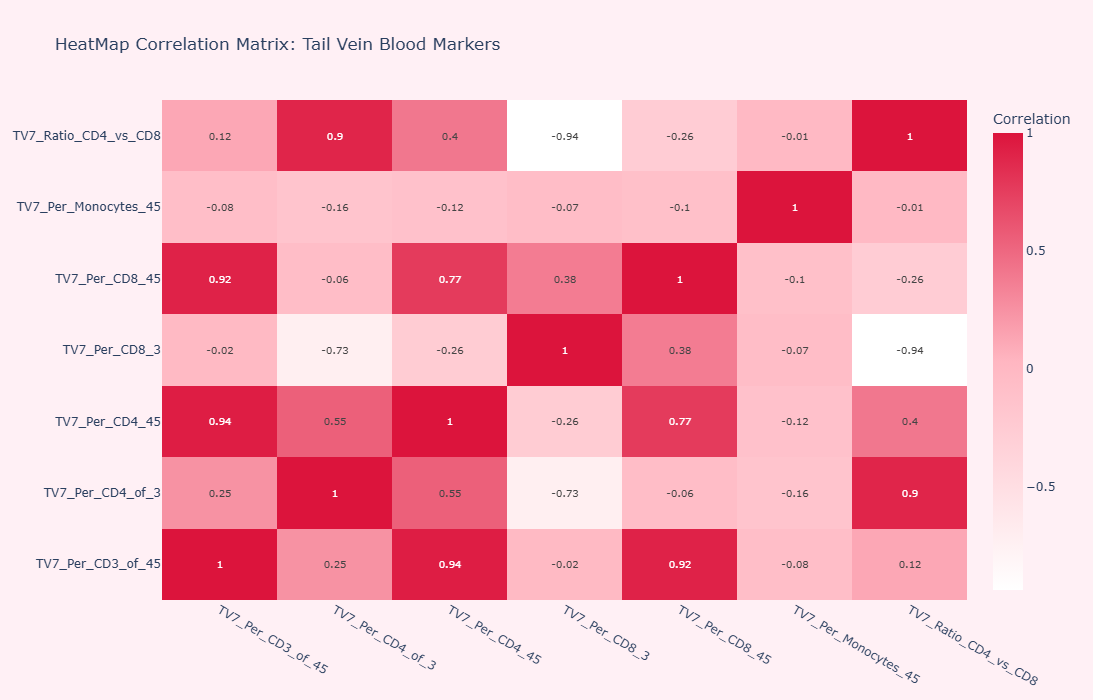

In [30]:
tv7_cols = [col for col in numeric_cols if 'TV7' in col]

if df is not None and len(tv7_cols) > 1:
    corr_matrix = df[tv7_cols].corr()

    fig = go.Figure(data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        colorscale=[
            [0, 'white'],
            [0.5, COLORS['secondary']],
            [1, COLORS['accent']]
        ],
        text=corr_matrix.values.round(2),
        texttemplate='%{text}',
        textfont={"size": 10},
        colorbar=dict(
            title="Correlation",
            tickmode="linear",
            tick0=-1,
            dtick=0.5
        )
    ))

    fig.update_layout(
        title="HeatMap Correlation Matrix: Tail Vein Blood Markers",
        height=700,
        width=800,
        paper_bgcolor=COLORS['background']
    )

    fig.show()

## boxplots!!

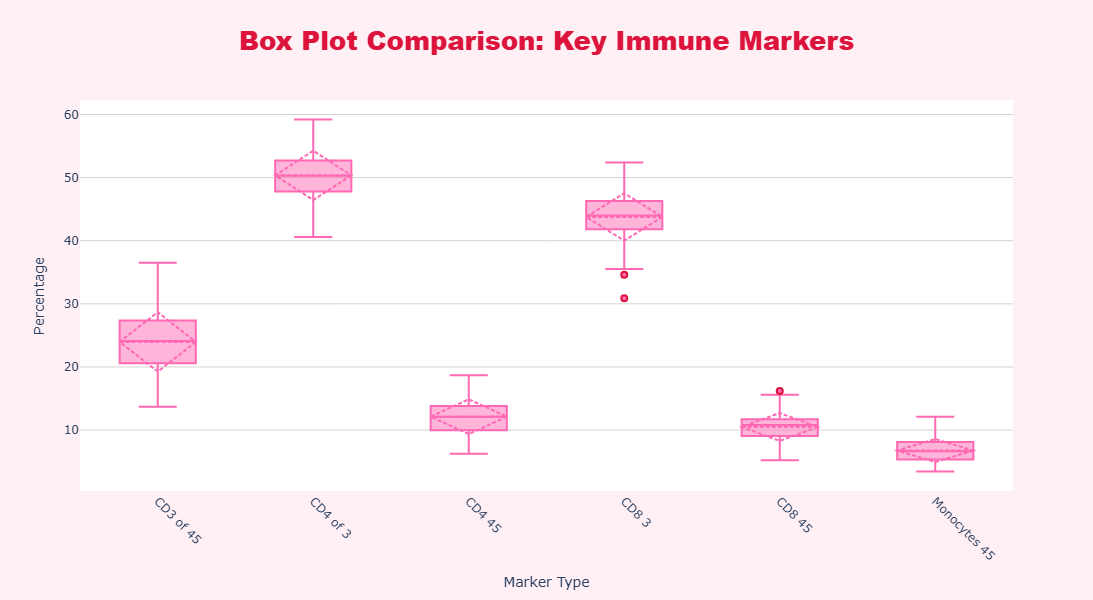

In [31]:
if df is not None and len(numeric_cols) > 0:
    key_markers = [col for col in tv7_cols if any(x in col for x in ['CD3', 'CD4', 'CD8', 'Monocytes'])][:6]
    
    fig = go.Figure()
    
    for idx, col in enumerate(key_markers):
        fig.add_trace(go.Box(
            y=df[col].dropna(),
            name=col.replace('TV7_Per_', '').replace('_', ' '),
            marker_color=COLORS['primary'],
            marker_line_color=COLORS['accent'],
            marker_line_width=2,
            boxmean='sd'
        ))
    
    fig.update_layout(
        title={
            'text': 'Box Plot Comparison: Key Immune Markers',
            'font': {'size': 26, 'color': COLORS['accent'], 'family': 'Arial Black'},
            'x': 0.5,
            'xanchor': 'center'
        },
        yaxis_title='Percentage',
        xaxis_title='Marker Type',
        height=600,
        plot_bgcolor='white',
        paper_bgcolor=COLORS['background'],
        showlegend=False
    )
    
    fig.update_xaxes(tickangle=45, showgrid=False)
    fig.update_yaxes(showgrid=True, gridcolor='lightgray')
    
    fig.write_html(f"{output_dir}/slide4_boxplots.html")
    fig.show()

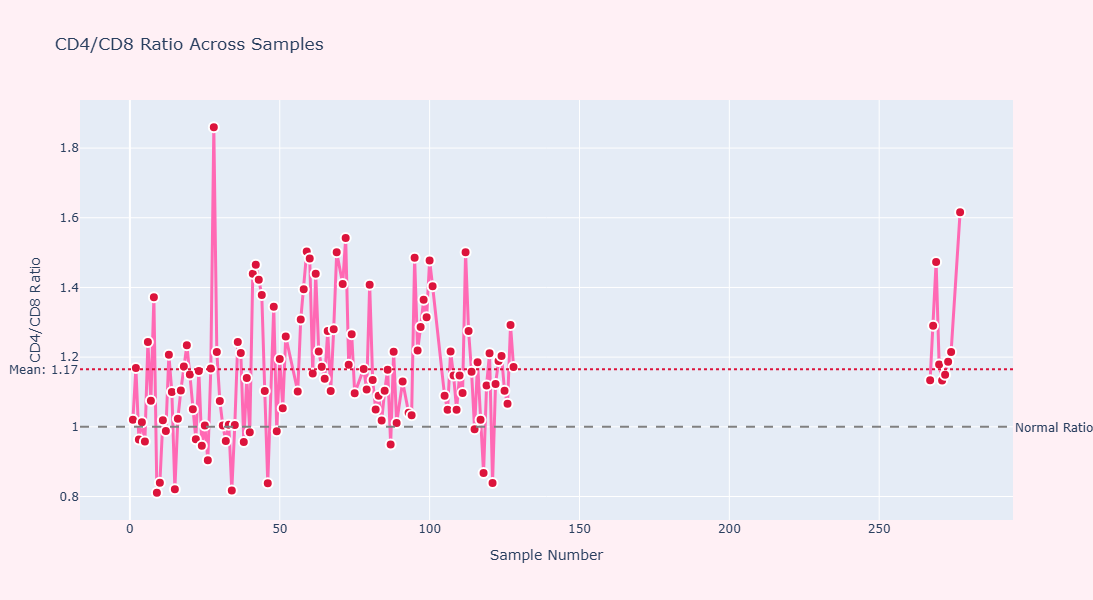

In [35]:
if df is not None:
    df['Sample_Num'] = df['Sample Name'].str.extract(r'(\d+)').astype(float)
    df = df.dropna(subset=['Sample_Num'])

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df['Sample_Num'],
        y=df['TV7_Ratio_CD4_vs_CD8'],
        mode='lines+markers',
        name='CD4/CD8 Ratio',
        line=dict(color=COLORS['primary'], width=3),
        marker=dict(
            size=10,
            color=COLORS['accent'],
            line=dict(color='white', width=2)
        )
    ))

    fig.add_hline(
        y=1,
        line_dash="dash",
        line_color="gray",
        annotation_text="Normal Ratio (1.0)",
        annotation_position="right"
    )

    mean_ratio = df['TV7_Ratio_CD4_vs_CD8'].mean()
    fig.add_hline(
        y=mean_ratio,
        line_dash="dot",
        line_color=COLORS['accent'],
        annotation_text=f"Mean: {mean_ratio:.2f}",
        annotation_position="left"
    )

    fig.update_layout(
        title="CD4/CD8 Ratio Across Samples",
        xaxis_title="Sample Number",
        yaxis_title="CD4/CD8 Ratio",
        height=600,
        paper_bgcolor=COLORS['background'],
        hovermode="x unified"
    )

    fig.show()

Statistics Summary


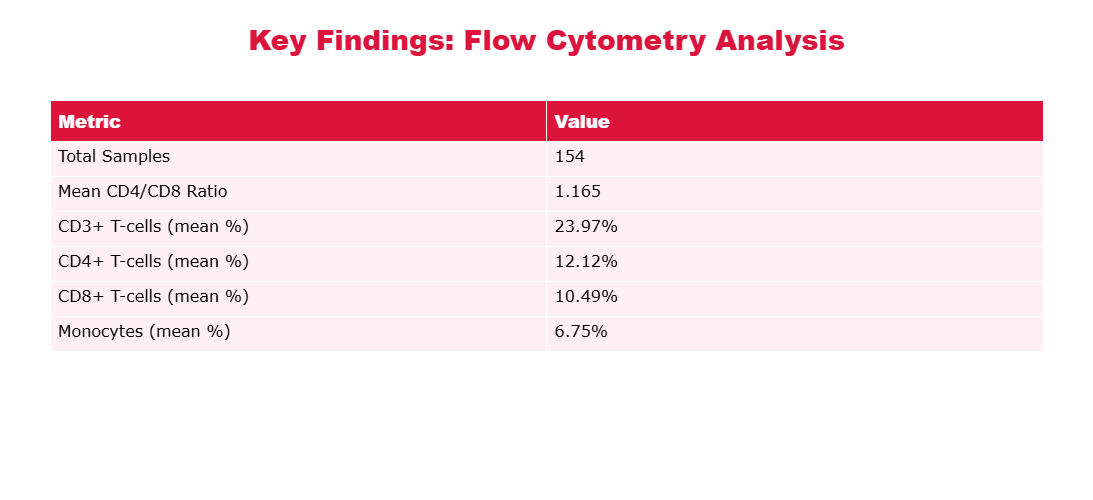

In [37]:
if df is not None:
    print("Statistics Summary")
   
    stats_data = {
        'Metric': [
            'Total Samples',
            'Mean CD4/CD8 Ratio',
            'CD3+ T-cells (mean %)',
            'CD4+ T-cells (mean %)',
            'CD8+ T-cells (mean %)',
            'Monocytes (mean %)'
        ],
        'Value': [
            len(df),
            f"{df['TV7_Ratio_CD4_vs_CD8'].mean():.3f}",
            f"{df['TV7_Per_CD3_of_45'].mean():.2f}%",
            f"{df['TV7_Per_CD4_45'].mean():.2f}%",
            f"{df['TV7_Per_CD8_45'].mean():.2f}%",
            f"{df['TV7_Per_Monocytes_45'].mean():.2f}%"
        ]
    }
    
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=['<b>Metric</b>', '<b>Value</b>'],
            fill_color=COLORS['accent'],
            align='left',
            font=dict(color='white', size=18, family='Arial Black'),
            height=40
        ),
        cells=dict(
            values=[stats_data['Metric'], stats_data['Value']],
            fill_color=[COLORS['background']],
            align='left',
            font=dict(color='black', size=16),
            height=35
        )
    )])
    
    fig.update_layout(
        title={
            'text': 'Key Findings: Flow Cytometry Analysis',
            'font': {'size': 28, 'color': COLORS['accent'], 'family': 'Arial Black'},
            'x': 0.5,
            'xanchor': 'center'
        },
        height=500,
        margin=dict(l=50, r=50, t=100, b=50)
    )
    
    fig.write_html(f"{output_dir}/slide6_summary.html")
    fig.show()

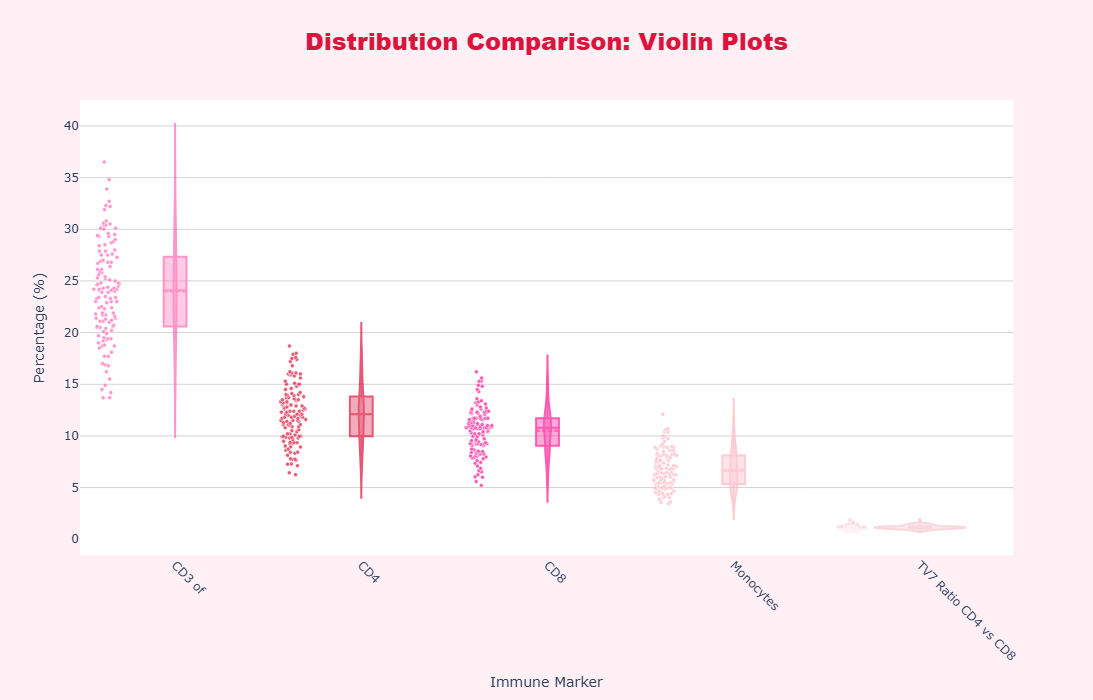

In [3]:
import pandas as pd
import plotly.express as px


filename = r"C:\Users\latte\OneDrive\Desktop\Radiation Cognition Spaceflight\Data\Raw\LSDS-122_Flow_Cytometry_Krukowski2021_Blood_Flow_TRANSFORMED.csv"

df = pd.read_csv(filename)


for col in df.columns:
    if col != 'Sample Name':
        df[col] = pd.to_numeric(df[col], errors='coerce')

violin_data = []
markers_for_violin = ['TV7_Per_CD3_of_45', 'TV7_Per_CD4_45', 'TV7_Per_CD8_45', 
                      'TV7_Per_Monocytes_45', 'TV7_Ratio_CD4_vs_CD8']

for col in markers_for_violin:
    for val in df[col].dropna():
        violin_data.append({
            'Marker': col.replace('TV7_Per_', '').replace('_45', '').replace('_of_', ' of ').replace('_', ' '),
            'Percentage': val
        })

violin_df = pd.DataFrame(violin_data)

fig = px.violin(
    violin_df,
    y='Percentage',
    x='Marker',
    box=True,
    points='all',
    color='Marker',
    color_discrete_sequence=['#FF69B4', '#DC143C', '#FF1493', '#FFB6C1', '#f7c6d0'],
    title='Distribution Comparison: Violin Plots with Individual Data Points'
)

fig.update_traces(
    meanline_visible=True,
    opacity=0.7,
    marker=dict(size=4, line=dict(width=0.5, color='white'))
)

fig.update_layout(
    title={'text': 'Distribution Comparison: Violin Plots',
           'font': {'size': 24, 'color': '#DC143C', 'family': 'Arial Black'},
           'x': 0.5, 'xanchor': 'center'},
    xaxis_title='Immune Marker',
    yaxis_title='Percentage (%)',
    height=700,
    paper_bgcolor='#FFF0F5',
    plot_bgcolor='white',
    showlegend=False,
    hovermode='closest'
)

fig.update_xaxes(tickangle=45, showgrid=False)
fig.update_yaxes(showgrid=True, gridcolor='lightgray')

fig.show()